In [1]:
# @title foo
#!pip install transformers==4.1.1 plotnine

## Setting stuff up

In [2]:
import re
import itertools

import numpy as np
import pandas as pd

from IPython.display import HTML
import seaborn
import matplotlib

from ahviz import create_indices, create_dataframe, filter_mask
import torch
from transformers import AutoModel, AutoTokenizer

from attention_graph_util import *

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [4]:
# uncomment this if you run into memory issues on the gpu
device = torch.device("cpu")

In [5]:
transformer = "bert-base-cased"
#transformer = "gpt2"
#transformer = "gpt2-medium"
#transformer = "gpt2-large"
#transformer = "twmkn9/bert-base-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(transformer)

# gpt2 doesn't do padding, so invent a padding token
# this one was suggested by the error you get when trying
# to do masking below, but it shouldn't matter as the actual
# tokens get ignored by the attention mask anyway
if transformer in ['gpt2', 'gpt2-medium', 'gpt2-large']:
    tokenizer.pad_token = tokenizer.eos_token

model = AutoModel.from_pretrained(transformer, output_attentions=True, output_hidden_states=True)
model.to(device)
model.eval()
model.zero_grad()


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
dataset_a = pd.read_csv("firsthalf.txt", sep="\t", header=None, names=["line"])

In [7]:
dataset_b = pd.read_csv("secondhalf.txt", sep="\t", header=None, names=["line"])

In [35]:
dataset_b['line'] = dataset_b['line'].str.split().apply(lambda l: " ".join(list(reversed(l))))

### To test things out, only use the first 100 lines of the datasets, so everything will go faster:

In [37]:
dataset_a = dataset_a.head(100)
dataset_b = dataset_b.head(100)

In [38]:
# an example of a synthetic dataset
#dataset_b = pd.DataFrame(["one two three four five six seven eight nine ten"] * 100, columns=["line"])

### window size and context

We move a sliding window over the complete dataset so we can always have context around the part we are looking at. This sets up how many tokens the model looks at each step, and with what step size to move through the corpus

- `window_size`:  
    the number of tokens that are in context

- `step`:  
    how many tokens we move ahead in each step through the corpus

- `future`:  
    how many tokens the model can look ahead
    
The mask printed below shows the effect of changing these values. The ones are the tokens we calculate things for, and the zeros are the extra context that the tokens of interest can pay attention to. For models like *GPT2*, `future` should be $0$, as the model only looks back 

In [39]:
window_size = 50
step = 25
future = 0

mask = torch.cat((torch.zeros(window_size - (step + future)), torch.ones(step), torch.zeros(future))).expand((100,-1))[0]
print(mask)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


In [40]:
input_tensors = []
for half in [dataset_a, dataset_b]:
    tokenized_sents = tokenizer(half['line'].tolist(), add_special_tokens=False)['input_ids']
    if not "gpt" in transformer:
        separated = map(lambda s: s + [tokenizer.sep_token_id], tokenized_sents)
    else:
        separated = tokenized_sents
    chained = list(itertools.chain.from_iterable(separated))
    tokens = torch.tensor(chained)
    pad_len = window_size - len(tokens) % window_size
    padded = torch.cat((tokens, tokens.new_full((pad_len,), tokenizer.pad_token_id)))
    input_tensors.append(padded)

In [41]:
def get_batches(input_tensor:torch.Tensor, size: int, step: int, batch_size :int = 2):
    input_ids = input_tensor.unfold(0, size, step)
    tensor_dataset = torch.utils.data.TensorDataset(input_ids)
    tensor_dataloader = torch.utils.data.DataLoader(tensor_dataset, batch_size=batch_size)
    
    return tensor_dataloader

In [42]:
%%time

result = None

for n, dataset in enumerate(input_tensors):
    dl = get_batches(dataset, window_size, step, batch_size=3)

    data = None
    for batch, t in enumerate(dl):
        input_dict = {k: v.to(device) for k, v in zip(["input_ids"], t)}

        output = model(**input_dict)

        att = np.array([a.cpu().detach().numpy() for a in output['attentions']])
        att = att.swapaxes(1,0)
        for s in range(att.shape[0]):
            att[s] = compute_joint_attention(att[s], layer_dim=1)

        # sort all the attention softmax vectors in descending order
        sorted = np.take_along_axis(att, (-att).argsort(), axis=-1)

        # add them up cumulatively
        cum = sorted.cumsum(axis=-1)

        # determine which ones are below 0.9
        limit = np.where(cum < 0.9, True, False)

        # count the ones below 0.9; k is that sum + 1
        k = limit.sum(axis=-1) + 1

        # swap the 'head' and 'sentence' axes so we can more easily apply the attention mask
        ks = np.swapaxes(k, 0, 2)
        if data is None:
            data = ks
        else:
            data = np.concatenate([data, ks], axis=2)
    ix = create_indices(data, names=['layer', 'head', 'sample', 'from_token'])
    df = create_dataframe(data, ix)
    df['dataset'] = n
    if result is None:
        result = df
    else:
        result = pd.concat([result, df])

CPU times: user 1min 14s, sys: 1.05 s, total: 1min 16s
Wall time: 19.3 s


In [43]:
att.shape

(3, 12, 12, 50, 50)

In [44]:
ks.shape

(12, 12, 3, 50)

In [45]:
result

,from_token,sample,head,layer,attention_fraction,dataset
0,1,1,1,1,25,0
1,2,1,1,1,26,0
2,3,1,1,1,30,0
3,4,1,1,1,32,0
4,5,1,1,1,30,0
...,...,...,...,...,...,...
842395,46,117,12,12,37,1
842396,47,117,12,12,37,1
842397,48,117,12,12,37,1
842398,49,117,12,12,37,1


In [46]:
filtered = result[(result['from_token']>(window_size-(step+future))) & (result['from_token']<=(window_size-future)) ].rename(columns={'attention_fraction': "value"})

In [47]:
avg_k = filtered.groupby(['dataset', 'layer', 'head']).agg(avg_k = pd.NamedAgg('value', np.median)).reset_index()

In [48]:
pivoted = avg_k.pivot(index=['layer', 'head'], columns='dataset', values="avg_k").reset_index()
pivoted['diff'] = pivoted[0] - pivoted[1]

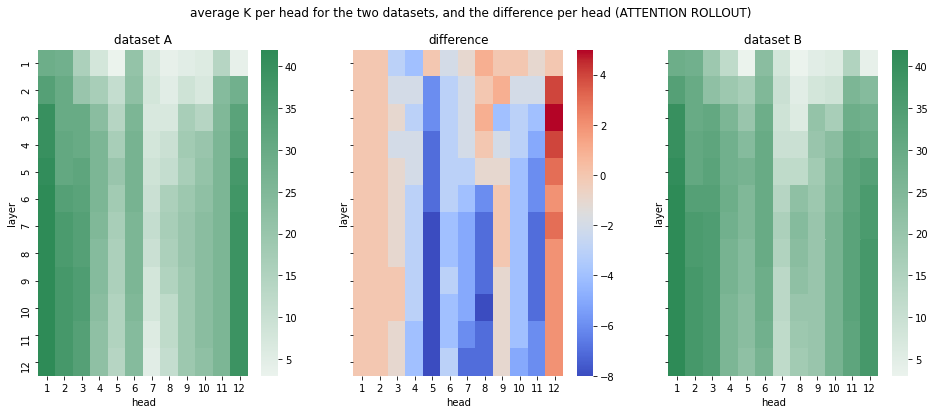

In [49]:
fig, axes = matplotlib.pyplot.subplots(1, 3, figsize=(16, 6), sharey=True)
fig.suptitle('average K per head for the two datasets, and the difference per head (ATTENTION ROLLOUT)')

seaborn.heatmap(ax=axes[0], data=avg_k[avg_k['dataset'] == 0].pivot('layer', 'head', "avg_k"), cmap=seaborn.light_palette("seagreen", as_cmap=True))
axes[0].set_title("dataset A")

(seaborn.heatmap(ax=axes[1], data=pivoted.pivot(['layer'], 'head', 'diff'), cmap=seaborn.color_palette("coolwarm", as_cmap=True)))
axes[1].set_title("difference")

seaborn.heatmap(ax=axes[2], data=avg_k[avg_k['dataset'] == 1].pivot('layer', 'head', "avg_k"), cmap=seaborn.light_palette("seagreen", as_cmap=True))
axes[2].set_title("dataset B")

matplotlib.pyplot.show()

In [21]:
avg_k.pivot(['dataset','layer'], 'head', "avg_k")

head           1   2   3   4   5   6   7   8   9   10  11  12
dataset layer                                                
0       1      29  28  16   8   3  21   7   4   5   6  14   4
        2      34  30  20  17  11  22   8   5   9   7  24  28
        3      40  30  30  23  14  26   7   7  17  14  25  33
        4      40  31  30  26  17  27   8  10  18  20  26  34
        5      41  31  32  26  20  27   9  11  17  21  26  37
        6      42  34  33  26  18  27  10  16  19  22  26  38
        7      42  36  34  25  17  26  11  17  20  23  26  39
        8      42  36  34  24  16  26  10  16  20  23  26  39
        9      42  37  35  24  16  26   8  15  19  23  26  39
        10     42  37  35  23  15  25   8  12  19  23  26  39
        11     42  37  34  22  15  24   6  12  19  23  26  39
        12     42  37  34  22  14  24   5  11  19  22  26  39
1       1      29  28  17   8   3  22   7   3   5   6  14   4
        2      34  30  20  17  10  23   8   5   9   7  24  28
        3      40  30  30  24  14  27   7   7  18  14  26  33
        4      40  31  31  27  18  28   9  11  18  21  26  34
        5      41  31  32  27  21  28  10  12  18  22  27  37
        6      42  34  33  27  19  28  11  17  20  23  27  38
        7      42  36  35  26  19  28  12  19  21  24  27  38
        8      42  36  35  25  18  28  11  18  21  24  27  39
        9      42  37  35  25  18  27  10  17  21  24  27  39
        10     42  37  35  24  17  27  10  15  20  24  27  39
        11     42  37  35  24  17  26   8  15  20  24  27  39
        12     42  37  35  24  15  26   8  14  20  24  27  39

### To replicate the plot in the hopfield network paper better, add a `sorted_head` column just so we can plot the attention heads per layer sorted from small to large k

In [22]:
d, l, h = avg_k['dataset'].max() + 1, avg_k['layer'].max(), avg_k['head'].max()
print(d,l,h)

2 12 12


In [23]:
sorted_avg_k = avg_k.sort_values(["dataset", "layer", "avg_k"]) 
sorted_avg_k['sorted_head'] = np.tile(np.tile(np.arange(h) + 1, l), d)


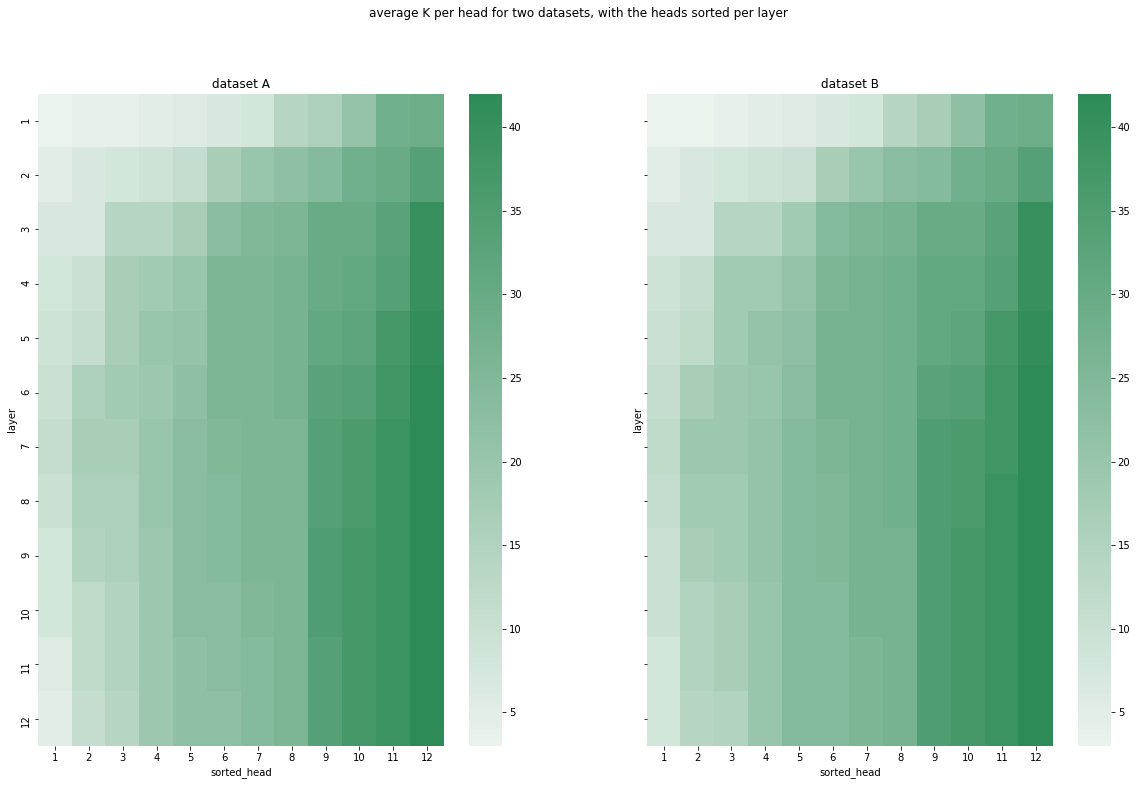

In [24]:
fig, axes = matplotlib.pyplot.subplots(1, 2, figsize=(20, 12), sharey=True)
fig.suptitle('average K per head for two datasets, with the heads sorted per layer')

seaborn.heatmap(ax=axes[0], data=sorted_avg_k[sorted_avg_k['dataset'] == 0].pivot('layer', 'sorted_head', "avg_k"), cmap=seaborn.light_palette("seagreen", as_cmap=True))
axes[0].set_title("dataset A")

seaborn.heatmap(ax=axes[1], data=sorted_avg_k[sorted_avg_k['dataset'] == 1].pivot('layer', 'sorted_head', "avg_k"), cmap=seaborn.light_palette("seagreen", as_cmap=True))
axes[1].set_title("dataset B")

matplotlib.pyplot.show()


In [25]:
# merge this sorted_head column into the original data too
data_sh = filtered.merge(sorted_avg_k[['dataset', 'layer', 'head', 'sorted_head']], on=["dataset", "layer", "head"])

## More Plots

## first in the natural order of the layers/heads

CPU times: user 27.9 s, sys: 144 ms, total: 28.1 s
Wall time: 28.1 s


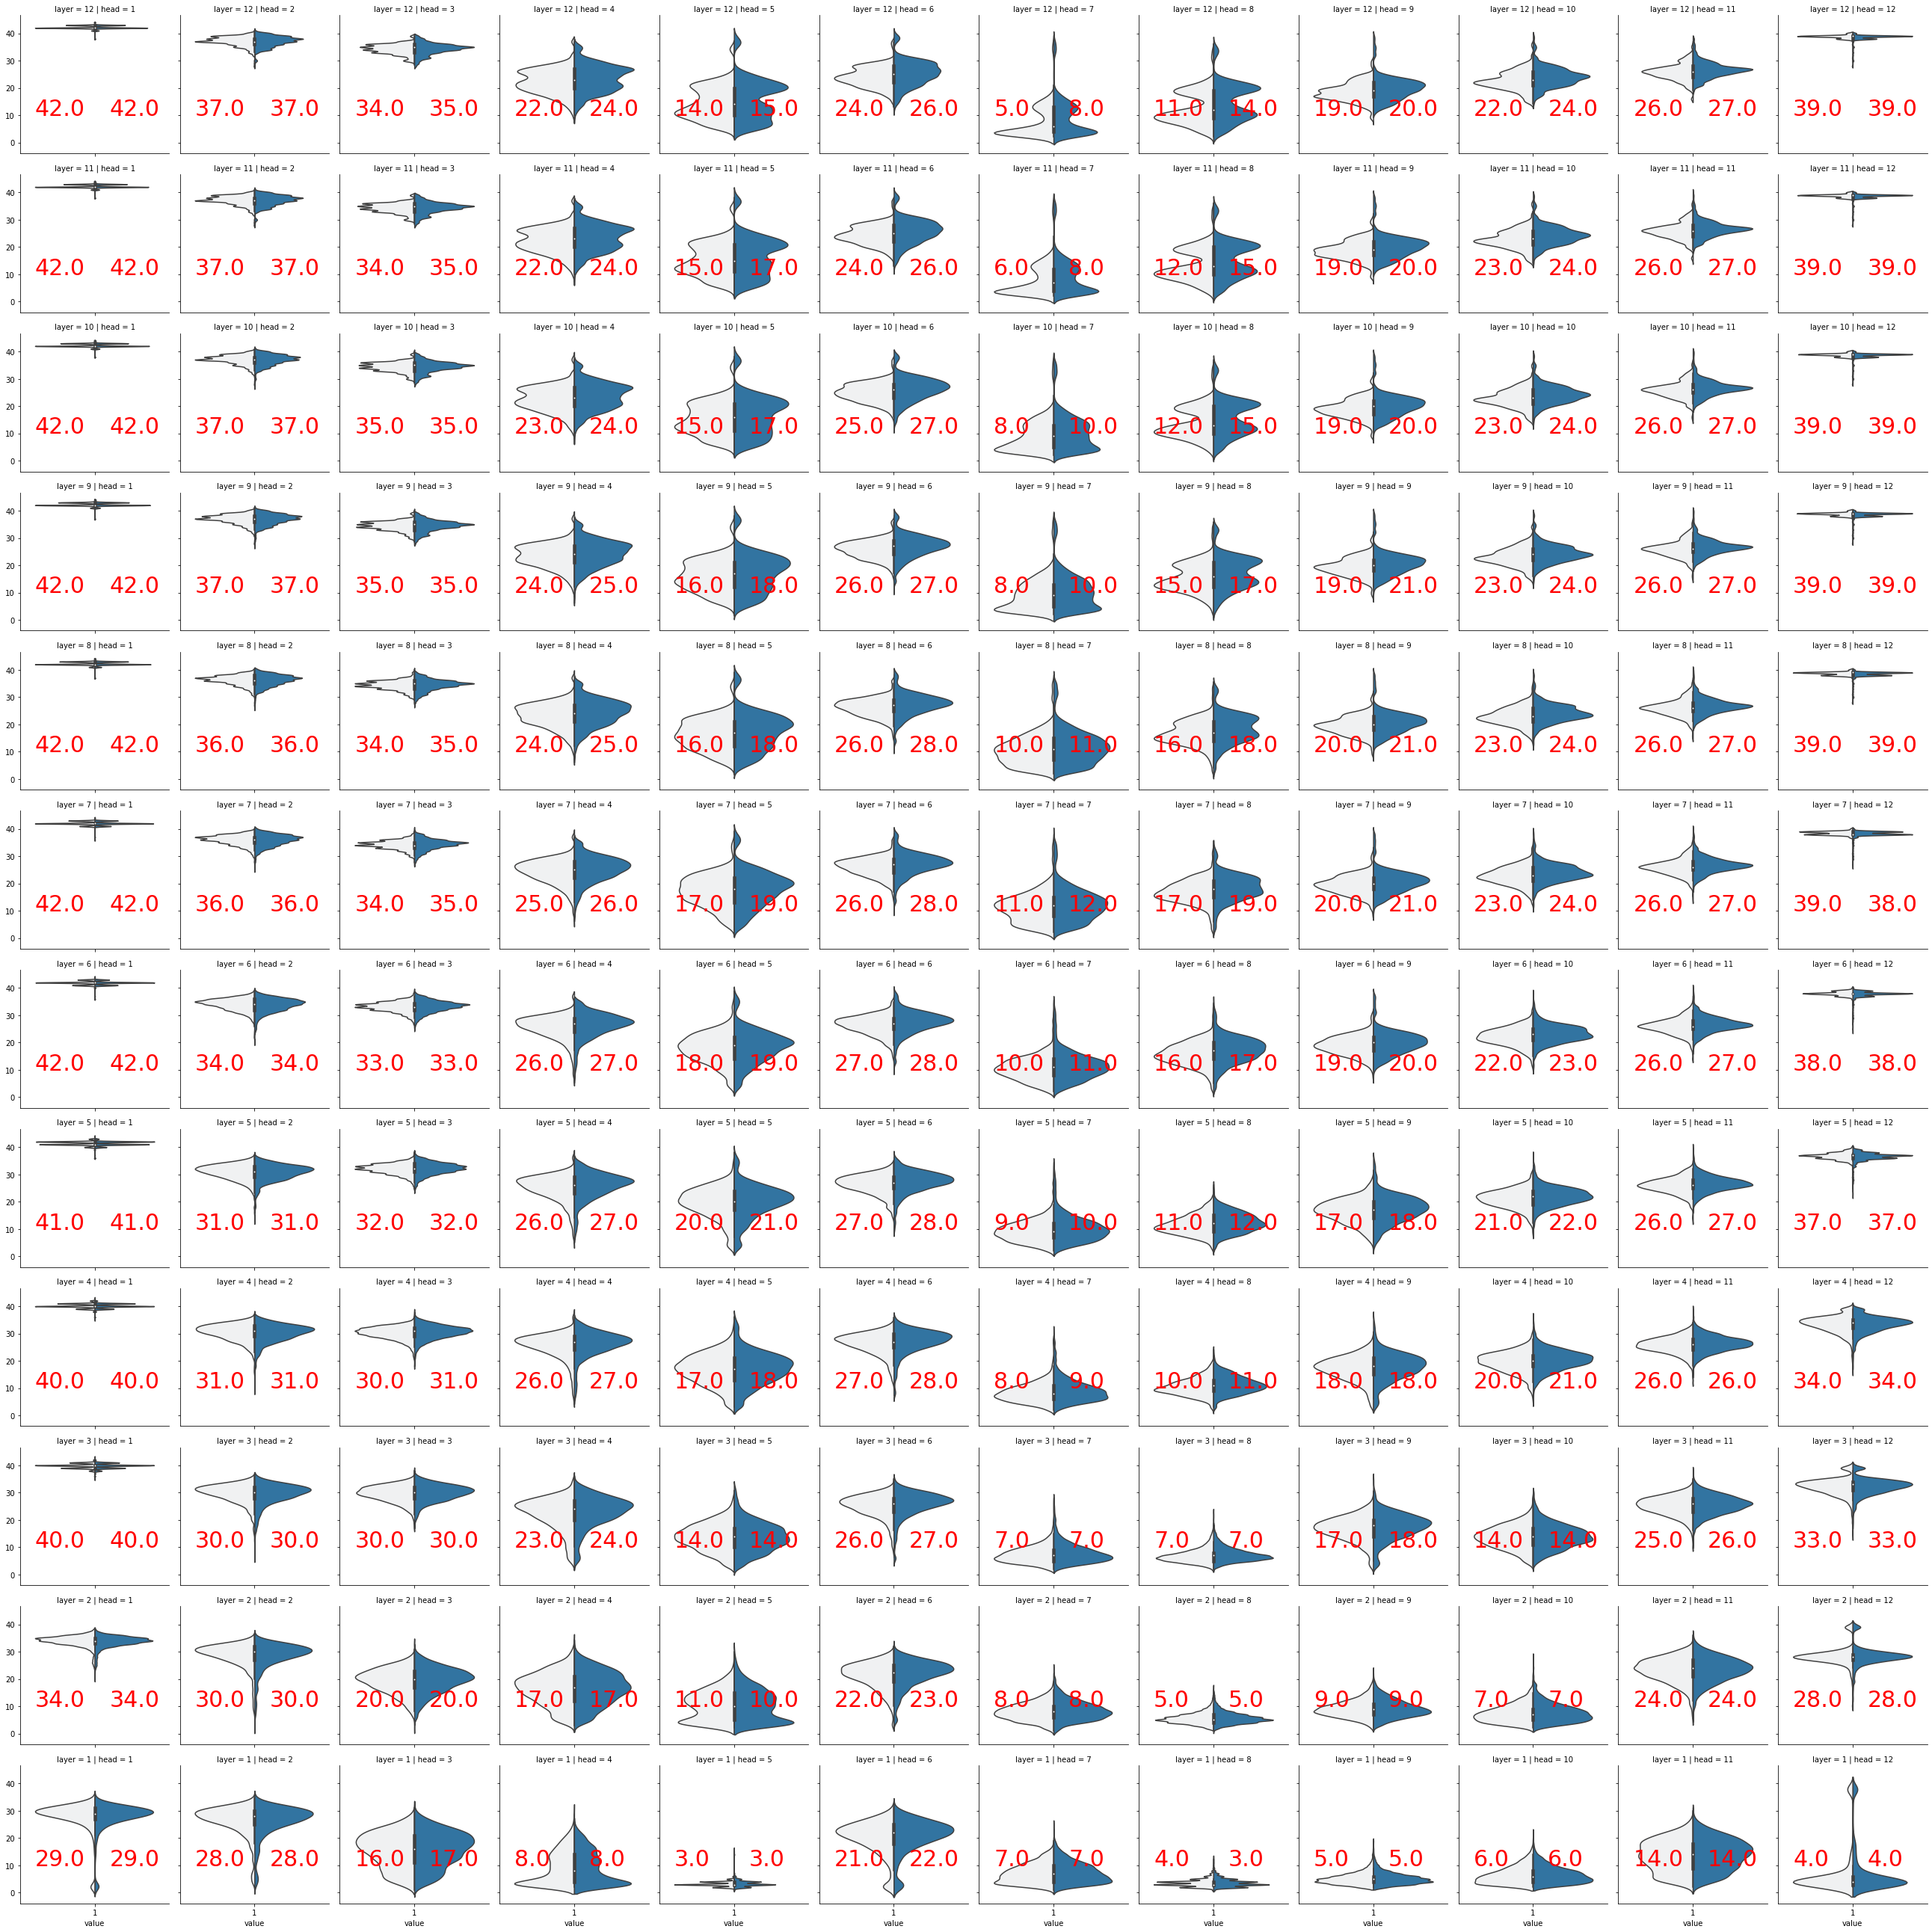

In [26]:
%%time
def make_violin(y, **kwargs):
    v = seaborn.violinplot(y=y,x="layer", hue="dataset", split=True, **kwargs)
    data = kwargs['data']
    for dataset in range(2):
        median_k = np.median(data[data['dataset'] == dataset][y])
        mean = np.mean(data[data['dataset'] == dataset][y])
        v.text(-0.4 + (dataset * 0.5), 10, str(median_k), fontdict=dict(color="red", fontsize=30))
    return v
g = seaborn.FacetGrid(data_sh, col="head",  row="layer", col_order=(np.arange(h) + 1), row_order=np.flip(np.arange(l) + 1))
g.map_dataframe(make_violin, "value")

### And the heads per layer sorted by the median k, like in the hopfield networks paper

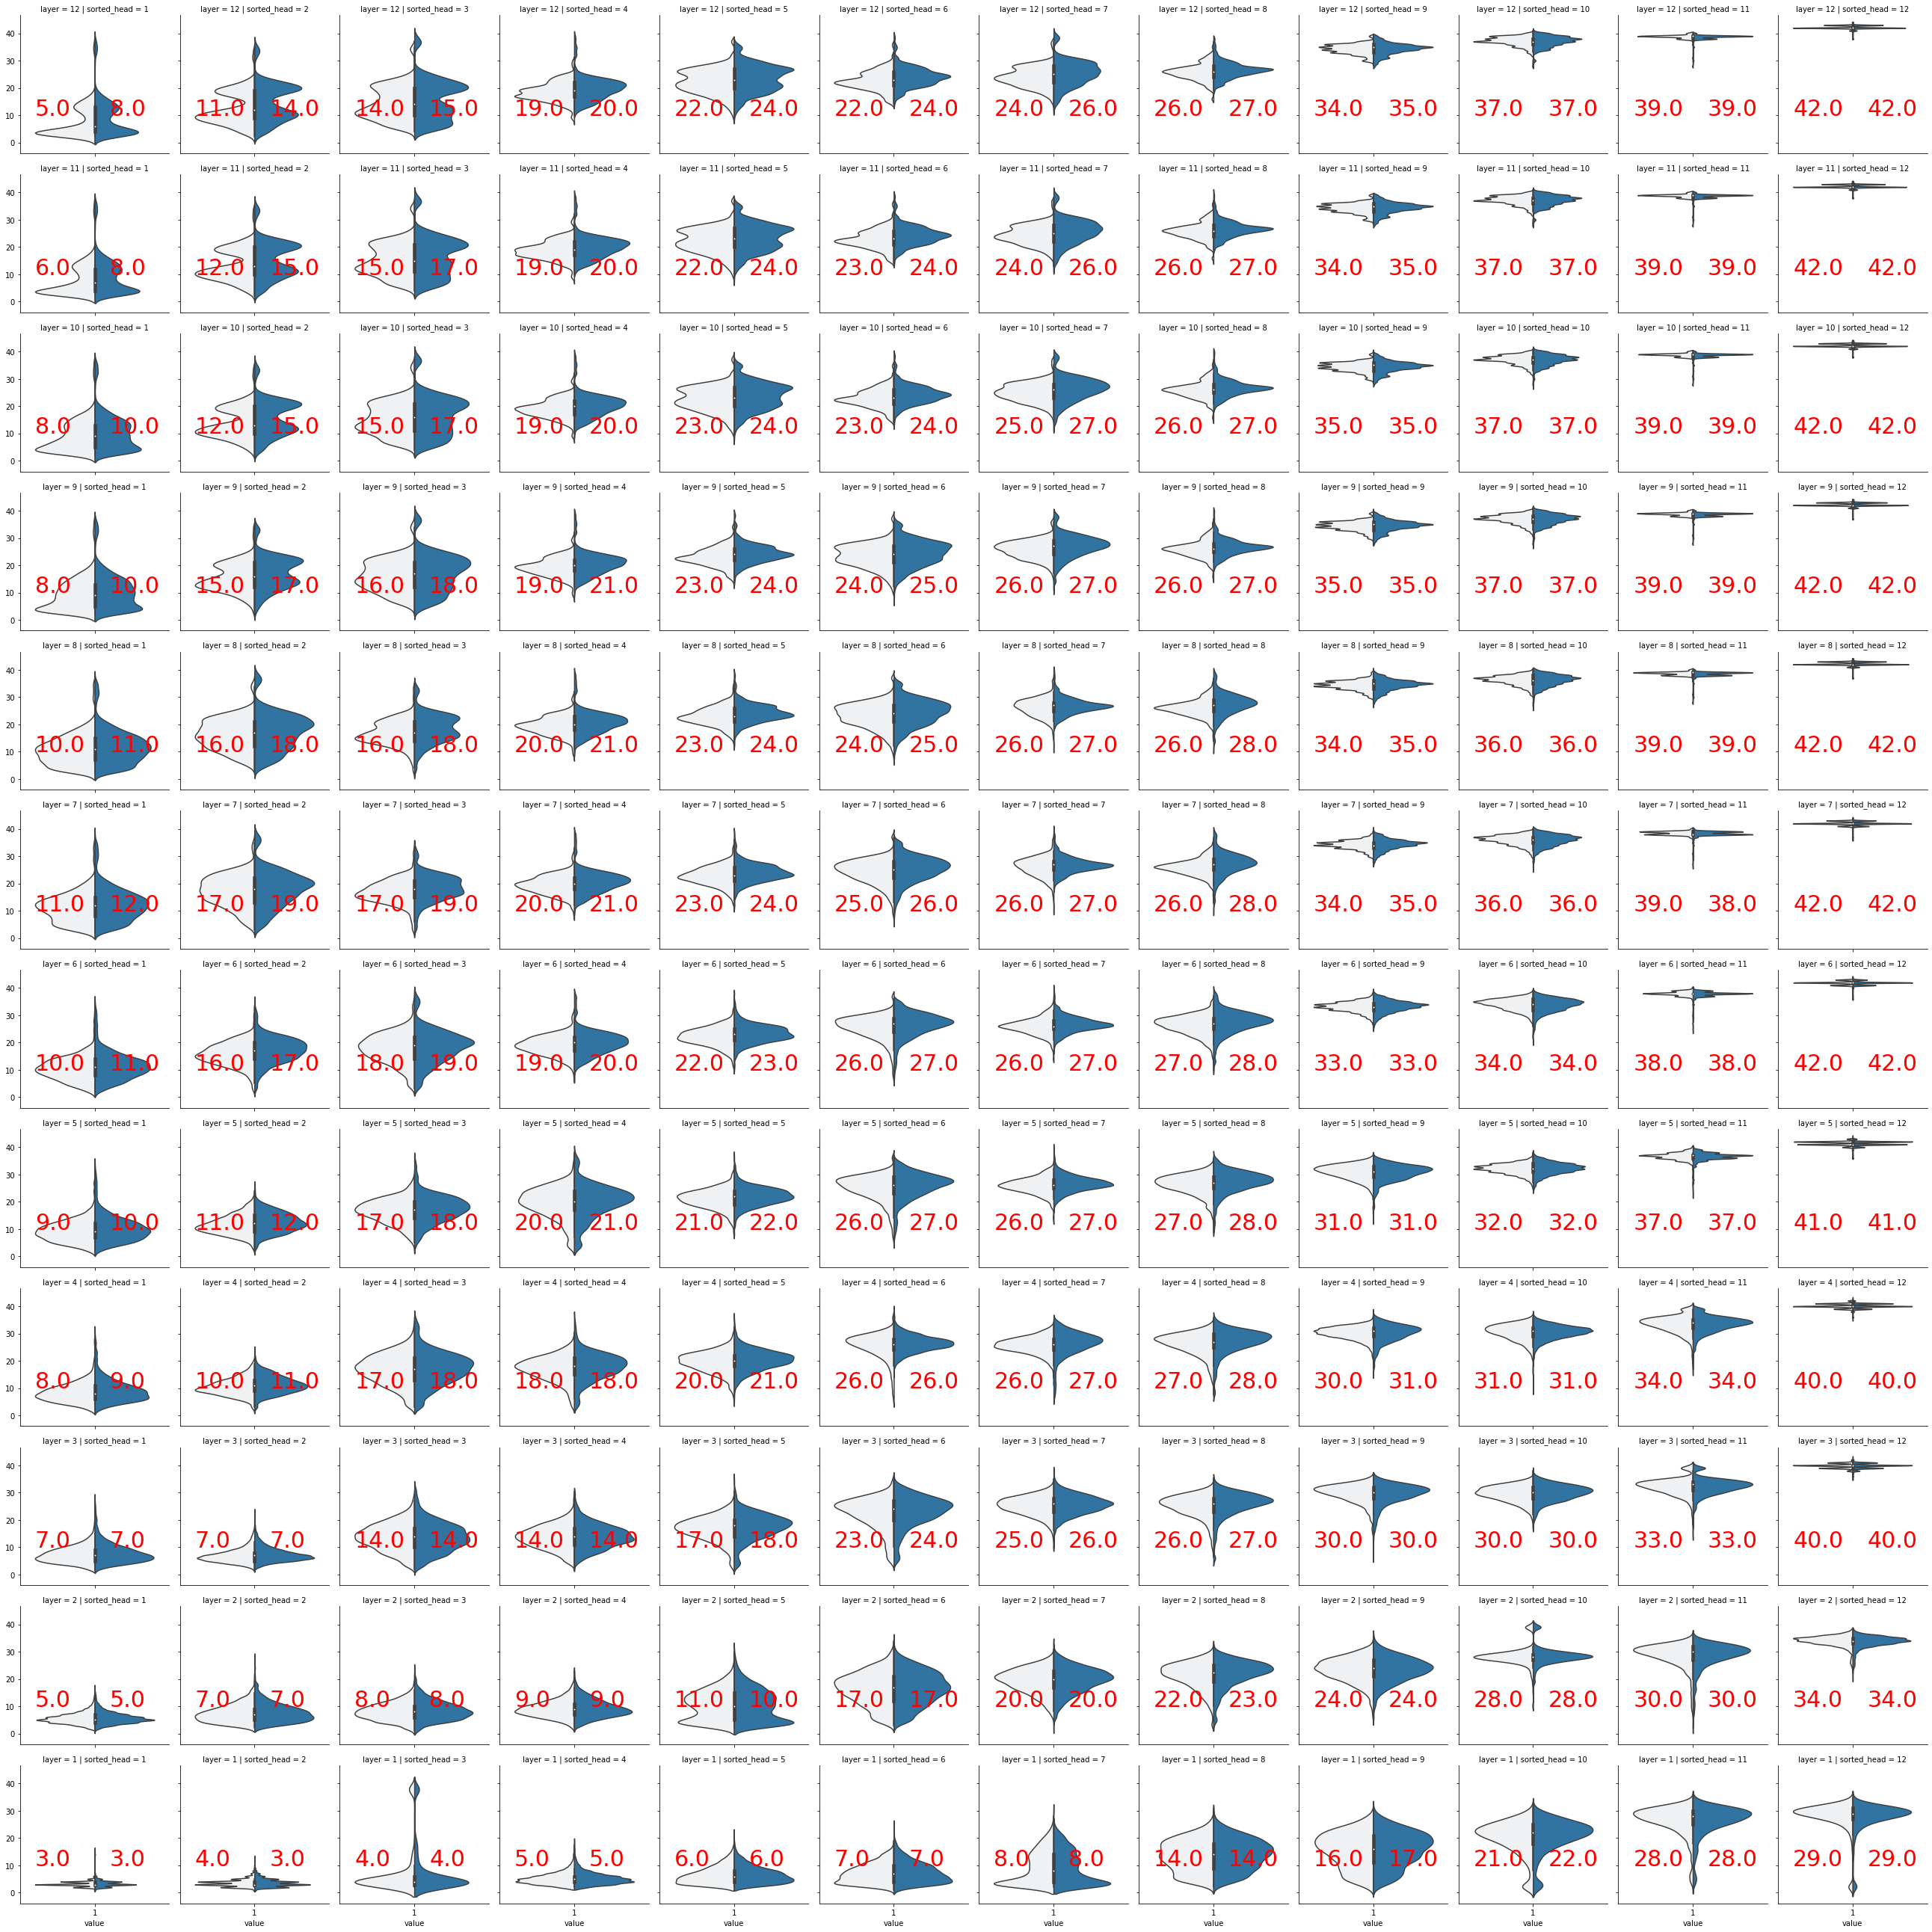

In [27]:
g = seaborn.FacetGrid(data_sh, col="sorted_head",  row="layer", col_order=(np.arange(h) + 1), row_order=np.flip(np.arange(l) + 1))
g.map_dataframe(make_violin, "value")